In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "admin",
                            database = "project")

cur = db.cursor()

# 1. List all unique cities where customers are located.

In [15]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Total Number of order in 2017

In [35]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017 '''
cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data)
f"Total Number of orders in 2017 is {data[0][0]}"

'Total Number of orders in 2017 is 45101'

# 3. Find the total sales per category.

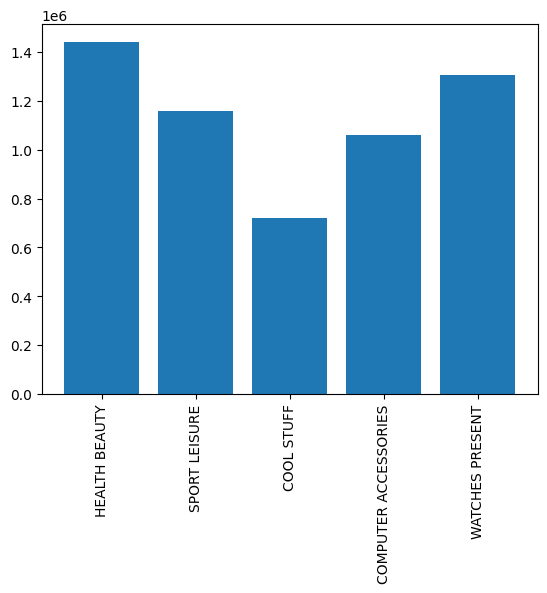

In [14]:
query = '''SELECT Upper(p.product_category), round(sum(o.price+o.freight_value),2) as Sales FROM project.order_items o
join products p on o.product_id = p.product_id
group by p.product_category  '''

cur.execute(query)

data = cur.fetchall()

df =  pd.DataFrame(data, columns = ['Product Category','Sales'])
df.sort_values(by = 'Sales', ascending = False)
df=df.head()
plt.bar(df['Product Category'], df['Sales'])
plt.xticks(rotation=90)
plt.show()

# 4. Calculate the percentage of orders that were paid in installments.

In [45]:
query = ''' Select round(sum(case when payment_installments>0 then 1 else 0 end)*100.00/count(*),5) as count from payments '''
cur.execute(query)
data = cur.fetchall()
f"The percentage of orders that have opt for installments payments {data[0][0]}"

'The percentage of orders that have opt for installments payments 99.99807'

# 5. Count the number of customers from each state.

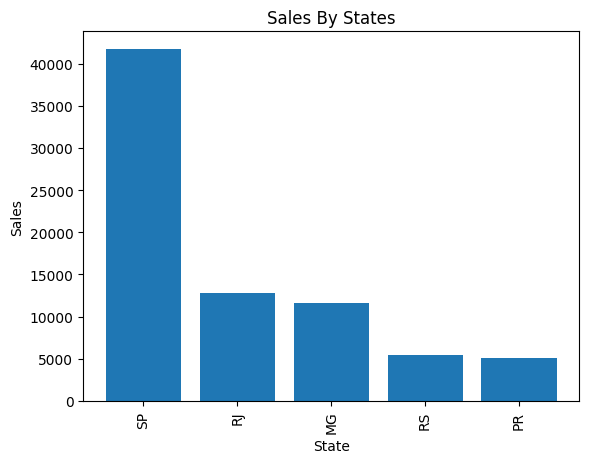

In [22]:
query = ''' SELECT customer_state, count(customer_id) FROM project.customers
group by customer_state'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['state','Customers Count'])
df = df.sort_values(by = 'Customers Count', ascending = 0)
df =df.head()
plt.bar(df['state'],df['Customers Count'])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.title("Sales By States")
plt.ylabel("Sales")
plt.show()

# 6. Number of Order in each month in 2018

<Axes: xlabel='Month', ylabel='Total_Orders'>

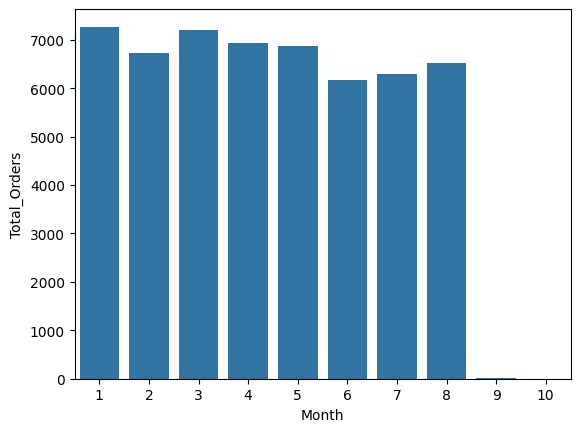

In [15]:
query = ''' Select month(order_purchase_timestamp) Months, count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by Months'''

cur.execute(query)

data= cur.fetchall()
df = pd.DataFrame(data, columns = ["Month","Total_Orders"])
df=df.sort_values(by = 'Month', ascending = True)
sns.barplot(x='Month',y= 'Total_Orders',data=df)

# 7. Find the average number of products per order, grouped by customer city.

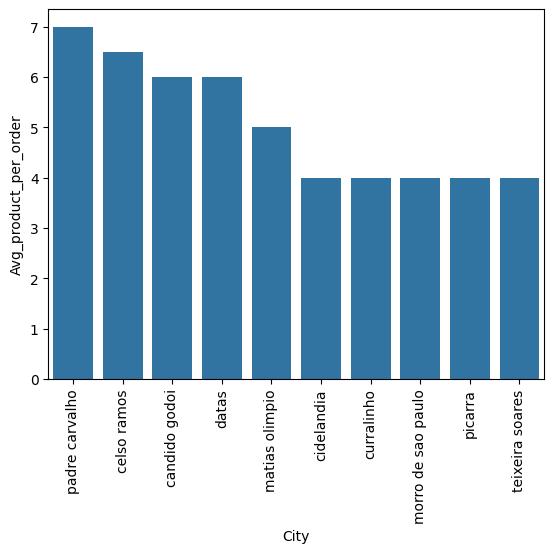

In [22]:
query = ''' SELECT c.customer_city, Round(count(i.product_id)/count(distinct i.order_id),2) as Avg_product_per_order FROM project.customers c
join orders o on c.customer_id =  o.customer_id
join order_items i on o.order_id = i.order_id
group by c.customer_city
order by Avg_product_per_order desc;
'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['city','Avg_product_per_order'])

df=df.head(10)
sns.barplot(x='city',y='Avg_product_per_order', data =df)
plt.xticks(rotation=90)
plt.xlabel('City')
plt.show()

# 8.Calculate the percentage of total revenue contributed by each product category.

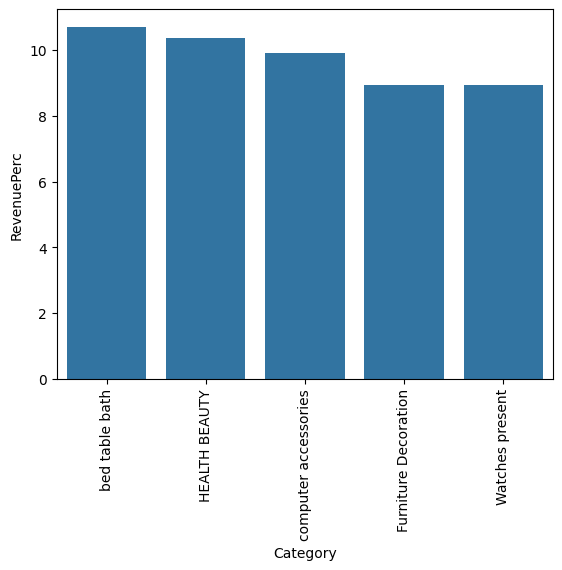

In [28]:
query = """ select p.product_category, round(sum(pa.payment_value)*100.00/(select sum(payment_value) from payments),2) as RevenuePer
from products p
join order_items o on p.product_id = o.product_id
join payments pa on o.order_id = pa.order_id
group by p.product_category
order by RevenuePer desc
limit 5"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Category', 'RevenuePerc'])
sns.barplot(x='Category',y='RevenuePerc',data=df)
plt.xticks(rotation=90)
plt.show()

# 9. Identify the correlation between avg product category price and the number of times a product has been purchased in each category.

In [29]:
query = """ Select p.product_category, count(o.product_id) ,round(avg(o.price),2) from products p
join order_items o on o.product_id = p.product_id
group by p.product_category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Product Cateogory', 'Number of orders', 'Avg. Price'])
a = df['Number of orders']
b = df['Avg. Price']
c = np.corrcoef([a,b])
f"The Corelation coefficient of price and product sold is {c[0][-1]}"

'The Corelation coefficient of price and product sold is -0.10631514167157562'

# 10. Calculate the total revenue generated by each seller, and rank them by revenue

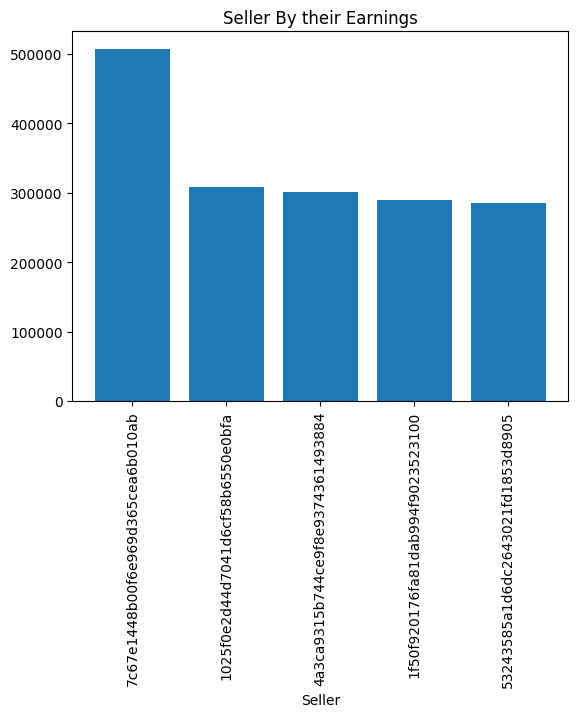

In [34]:
query = """ Select s.seller_id, round(sum(p.payment_value),2) as Seller_earning from order_items o
join sellers s on o.seller_id = s.seller_id
join payments p on o.order_id = p.order_id
group by s.seller_id
order by Seller_earning desc; """

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data,columns = ['seller','Revenue'])
df = df.head()
plt.bar(df['seller'],df['Revenue'])
plt.xticks(rotation=90)
plt.xlabel("Seller")
plt.title("Seller By their Earnings")
plt.show()

#  11. Calculate the moving average of order values for each customer over their order history.

In [6]:
query = """ with cte as(SELECT order_id, sum(price+freight_value) as ordervalue FROM project.order_items
group by order_id)

select c.customer_id,order_purchase_timestamp, ordervalue, avg(ordervalue) over(partition by c.customer_id order by order_purchase_timestamp asc) value from customers c
join orders o on c.customer_id = o.customer_id
join cte on o.order_id = cte.order_id; """

cur.execute(query)

data=cur.fetchall()
df =pd.DataFrame(data,columns = ['sellerID','Time','orderValue','MovingAvg'])
df.head()

,sellerID,Time,orderValue,MovingAvg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.740004,114.740004
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410002,67.410002
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.420006,195.420006
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.349995,179.349995
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010000,107.010000


# 12. Calculate the cumulative sales per month for each year.

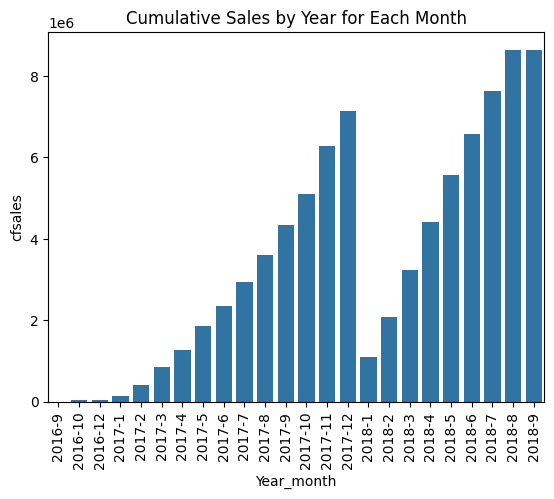

<Figure size 1200x600 with 0 Axes>

In [44]:
query = """ with cte as(select year(o.order_purchase_timestamp) as yearno, month(o.order_purchase_timestamp) as Monthno, Round(sum(oi.freight_value+oi.price),2) as Sales from orders o
join order_items oi on o.order_id= oi.order_id 
group by yearno, monthno
order by yearno asc, monthno asc)

select *, round(sum(Sales) over(partition by yearno order by monthno),2) as CfSales from cte """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ['Year','month','sales','cfsales'])
df['Year_month'] = df['Year'].astype(str)+'-'+df['month'].astype(str)
sns.barplot(x='Year_month', y='cfsales', data=df)
plt.title('Cumulative Sales by Year for Each Month')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 6))
plt.show()

# 13. YoY Growth

   Yearno       Sales         Y-O-Y
0    2016    57183.21           NaN
1    2017  7142672.43  12390.856022
2    2018  8643697.60     21.014896


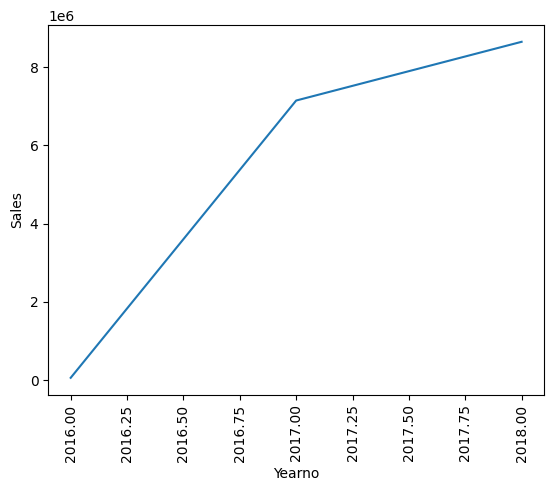

In [16]:
query = """ #Calculate the year-over-year growth rate of total sales.
with cte as(select year(o.order_purchase_timestamp) as Year, Round(sum(price+freight_value),2) Sales from orders o 
join order_items oi on o.order_id = oi.order_id
group by Year
order by Year asc)

select *,(Sales-(lag(Sales) over()))*100.00/(lag(Sales) over()) from cte """
cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns=['Yearno','Sales', 'Y-O-Y'])
print(df)
sns.lineplot(x='Yearno',y='Sales',data=df)
plt.xticks(rotation = 90)
plt.show()

# 14. Identify the top 3 customers who spent the most money in each year.

   year                      customers_ID         sales
0  2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.549999
1  2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.739990
2  2016  4a06381959b6670756de02e07b83815f   1227.780001
3  2017  1617b1357756262bfa56ab541c47bc16  13664.080002
4  2017  c6e2731c5b391845f6800c97401a43a9   6929.309998
5  2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.660004
6  2018  ec5b2ba62e574342386871631fafd3fc   7274.879997
7  2018  f48d464a0baaea338cb25f816991ab1f   6922.210007
8  2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.439896


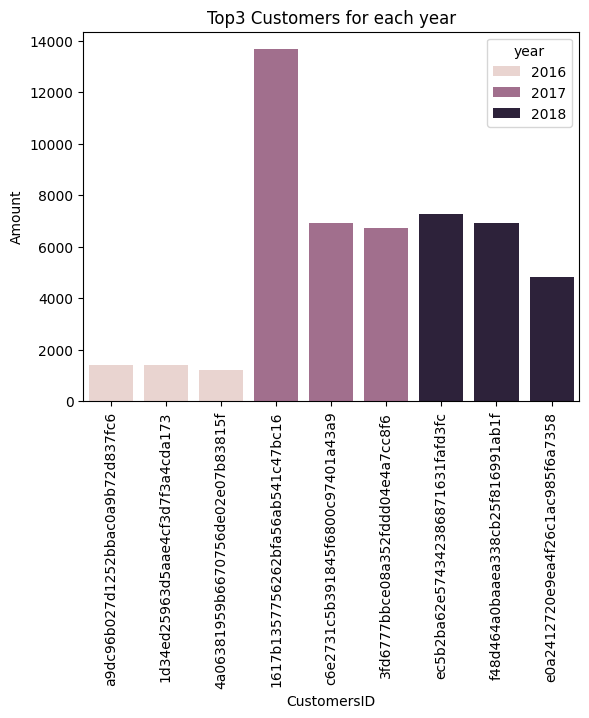

In [12]:
query = """ with cte as(Select order_id,sum(freight_value+price) Sales from order_items
group by order_id),

cte2 as(select year(o.order_purchase_timestamp) year, c.customer_id, Sum(sales) Total_Sales, row_number() over(partition by year(o.order_purchase_timestamp) order by Sum(sales) desc) rn from customers c
join orders o on c.customer_id = o.customer_id
join cte on o.order_id = cte.order_id
group by customer_id,Year
order by year,Sum(sales) desc)

select year,customer_id,Total_sales from cte2
where rn <=3; """

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns=['year','customers_ID','sales'])
print(df)
sns.barplot(x= 'customers_ID', y = 'sales',data =df, hue='year')
plt.xticks(rotation=90)
plt.xlabel('CustomersID')
plt.ylabel('Amount')
plt.title('Top3 Customers for each year')
plt.show()